# The baseline SVM model (downsampled for efficiency) used as benchmark

In [1]:
import keras
import glob
import numpy as np
import matplotlib.pyplot as plt

# #import the Sequential model class. 
# from tensorflow.keras.models import Sequential, Model
# from tensorflow.keras.utils import plot_model
# from tensorflow.keras import Input

# #Core layers 
# from tensorflow.keras.layers import Dense, Activation,Dropout,Flatten

# #Convolution layers 
# from tensorflow.keras.layers import Conv1D, Conv2D 

# from tensorflow.keras.layers import Concatenate, concatenate

# #Pooling layers 
# from tensorflow.keras.layers import MaxPooling1D, MaxPooling2D, AveragePooling1D, AveragePooling2D 

# #Recurrent layers 
# # from tensorflow.keras.layers import Recurrent, SimpleRNN, GRU, LSTM

# #Embedding layers 
# from tensorflow.keras.layers import Embedding

# #Merge layers 
# from tensorflow.keras.layers import Add, Multiply, Average, Maximum, Concatenate, Dot

# #Normalization layers 
# from tensorflow.keras.layers import BatchNormalization 

# from tensorflow.keras.models import load_model

from scipy.stats import spearmanr, pearsonr

Using TensorFlow backend.
/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py

In [2]:
downsample_rate = 10

def process_data():
    test_X_files = glob.glob(dir_name+'/sequences/test*')
    example_file = np.load(test_X_files[0], allow_pickle=True)
    num_bp = int(example_file.size/4)
    print("test_X_files:", len(test_X_files))
    num_examples = int((len(test_X_files))/downsample_rate)
    test_X = np.empty((num_examples, num_bp, 4), dtype=np.float32)
    for i in range(num_examples):
        test_X_file = test_X_files[i]
        example = np.load(test_X_file, allow_pickle=True)
        np.resize(example, (num_bp, 4))
        test_X[i,:,:] = example
    
    test_y_files = glob.glob(dir_name+'/peak_data/test*')
    example_file = np.load(test_y_files[0], allow_pickle=True)
    test_y = np.empty((num_examples, example_file.size))
    for i in range(num_examples):
        test_y_file = test_y_files[i]
        example = np.load(test_y_file, allow_pickle=True)
        test_y[i,:] = example
        
    train_X_files = glob.glob(dir_name+'/sequences/train*')
    example_file = np.load(train_X_files[0], allow_pickle=True)
    num_bp = int(example_file.size/4)
    print("train_X_files:", len(train_X_files))
    num_examples = int((len(train_X_files))/downsample_rate)
    train_X = np.empty((num_examples, num_bp, 4), dtype=np.float32)
    for i in range(num_examples):
        train_X_file = train_X_files[i]
        example = np.load(train_X_file, allow_pickle=True)
        np.resize(example, (num_bp, 4))
        train_X[i,:,:] = example
    
    train_y_files = glob.glob(dir_name+'/peak_data/train*')
    example_file = np.load(train_y_files[0], allow_pickle=True)   # fixed a typo here
    train_y = np.empty((num_examples, example_file.size))
    for i in range(num_examples):
        train_y_file = train_y_files[i]
        example = np.load(train_y_file, allow_pickle=True)
        train_y[i,:] = example
        
    val_X_files = glob.glob(dir_name+'/sequences/validation*')
    example_file = np.load(val_X_files[0], allow_pickle=True)
    num_bp = int(example_file.size/4)
    print("val_X_files:", len(val_X_files))
    num_examples = int((len(val_X_files))/downsample_rate)
    val_X = np.empty((num_examples, num_bp, 4), dtype=np.float32)
    
    return train_X, train_y, test_X, test_y、

In [3]:
# global vars
dir_name = '/data/smooth_muscle_cells'
normalization = True
max_peak_val = 3
# num_filters = 64
num_filters = 32
kernel_size = 24
pooling_size = 4
dilation_rate = 2
dropout_rate = 0.3

In [4]:
train_X_forward, train_y, test_X_forward, test_y = process_data()

test_X_files: 3673
train_X_files: 97451
val_X_files: 4519


In [6]:
# remove outliers & normalize
train_y[train_y > max_peak_val] = max_peak_val
test_y[test_y > max_peak_val] = max_peak_val
val_y[val_y > max_peak_val] = max_peak_val

train_X = train_X_forward
test_X = test_X_forward
val_X = val_X_forward

print(train_y.shape)
print(test_y.shape)
print(val_y.shape)

print(train_X.shape)
print(test_X.shape)
print(val_X.shape)

(9745, 3000)
(367, 3000)
(451, 3000)
(9745, 13000, 4)
(367, 13000, 4)
(451, 13000, 4)


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in greater
  


In [7]:
'''
Function to extract X & y data for benchmark regressor
(Those regressors predict one point at a time.)
'''
def extract_benchmark_data(sample_Xs, sample_ys, half_center_size,half_feature_size):
       
    half_y_length = int(np.floor(sample_ys.shape[1]/2))
    
    if (4*half_center_size) > sample_ys.shape[1]:
        print("ERROR: y out of range.")
        return [],[]
    if (2*half_feature_size+4*half_center_size) > sample_Xs.shape[1]:
        print("ERROR: X out of range.")
        return [],[]
    
    # from center
    # label (Y)
    lb_center_idx = int(np.ceil(sample_ys.shape[1]/2))
    lb_h_idx = lb_center_idx-half_center_size
    lb_t_idx = lb_center_idx+half_center_size
    seg_y = sample_ys[:,lb_h_idx:lb_t_idx]
    
    # add reference from non-peak    
    seg_y = np.concatenate((seg_y,
                            sample_ys[:,lb_center_idx-half_y_length:lb_center_idx-half_y_length+half_center_size],
                           sample_ys[:,lb_center_idx+half_y_length-half_center_size:lb_center_idx+half_y_length]),                          
                           axis=1)

    # feature (X)
    ft_center_idx = int(np.ceil(sample_Xs.shape[1]/2))
    ftlb_h_idx = ft_center_idx-half_center_size
    ftlb_t_idx = ft_center_idx+half_center_size

    seg_X = np.empty([sample_Xs.shape[0],1,2*half_feature_size*sample_Xs.shape[2]])
    for idx in range(ftlb_h_idx,ftlb_t_idx):
        ft_h_idx = idx-half_feature_size
        ft_t_idx = idx+half_feature_size
        seg_features_idx = sample_Xs[:,ft_h_idx:ft_t_idx,:]
        seg_features_idx = seg_features_idx.reshape(seg_features_idx.shape[0],1,-1)
        seg_X = np.concatenate((seg_X, seg_features_idx), axis=1)
    # add reference from non-peak    
    for idx in range(ft_center_idx-half_y_length,ft_center_idx-half_y_length+half_center_size):
        ft_h_idx = idx-half_feature_size
        ft_t_idx = idx+half_feature_size
        seg_features_idx = sample_Xs[:,ft_h_idx:ft_t_idx,:]
        seg_features_idx = seg_features_idx.reshape(seg_features_idx.shape[0],1,-1)
        seg_X = np.concatenate((seg_X, seg_features_idx), axis=1)
    for idx in range(ft_center_idx+half_y_length-half_center_size,ft_center_idx+half_y_length):
        ft_h_idx = idx-half_feature_size
        ft_t_idx = idx+half_feature_size
        seg_features_idx = sample_Xs[:,ft_h_idx:ft_t_idx,:]
        seg_features_idx = seg_features_idx.reshape(seg_features_idx.shape[0],1,-1)
        seg_X = np.concatenate((seg_X, seg_features_idx), axis=1)
        
    seg_X = seg_X[:,1:,:]
        

    # X and y for SVM 
    bm_X = seg_X.reshape(-1,seg_X.shape[-1])
    bm_y = seg_y.flatten()
    
    return bm_X,bm_y

In [8]:
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn import metrics 
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import LinearSVR

from scipy import sparse
import time
import random

In [9]:
# extract train/val/test data for benchmark regressor

# total_train = train_y.shape[0]
# total_test = test_y.shape[0]
# total_val = val_y.shape[0]

half_center_size = 2  # +/- values around a peak to predict
half_feature_size = 25 # +/- values around each point to take in as features

# indices = np.concatenate((range(3916),range(3916,train_y.shape[0])),axis=0)
indices = range(train_y.shape[0])

# num_train, num_val, num_test = 500, 100, 100
# idx_train = random.sample(range(total_train), num_train)
# idx_test = random.sample(range(total_test), num_val)
# idx_val = random.sample(range(total_val), num_test)

bm_train_X,bm_train_y = extract_benchmark_data(train_X[indices,:], train_y[indices,:], half_center_size,half_feature_size)
bm_test_X,bm_test_y = extract_benchmark_data(test_X, test_y, half_center_size,half_feature_size)
# bm_val_X,bm_val_y = extract_benchmark_data(val_X, val_y, half_center_size,half_feature_size)

# check 
print("Check the dimensions of data:")
print(bm_train_X.shape)
print(bm_train_y.shape)
print(bm_test_X.shape)
print(bm_test_y.shape)
# print(bm_val_X.shape)
# print(bm_val_y.shape)

# remove NaNs
nan_ind = np.where(np.isnan(bm_train_y))[0]
fixed_y = np.delete(bm_train_y,nan_ind)
fixed_X = np.delete(bm_train_X,nan_ind,0)
bm_train_y = fixed_y
bm_train_X = fixed_X

print("mean of train y:",np.mean(bm_train_y))
print("mean of test y:",np.mean(bm_test_y))
# print("mean of val y:",np.mean(bm_val_y))

Check the dimensions of data:
(77960, 200)
(77960,)
(2936, 200)
(2936,)
mean of train y: 1.5538261143409484
mean of test y: 1.5942719453801109


In [12]:
# sparse matrix
s_bm_train_X = sparse.csr_matrix(bm_train_X)
s_bm_test_X = sparse.csr_matrix(bm_test_X)

In [ ]:
# SVM
print("SVM Regression")

svm_regr = svm.SVR(gamma='scale')

tic = time.perf_counter()
svm_regr.fit(s_bm_train_X, bm_train_y) 
toc = time.perf_counter()

In [ ]:
from sklearn.externals import joblib

svm_regr = joblib.load('finalized_model.sav')


In [13]:
svm_pred_y = svm_regr.predict(s_bm_test_X)
svm_mse = metrics.mean_squared_error(bm_test_y, svm_pred_y)  
svm_r2 = metrics.r2_score(bm_test_y, svm_pred_y)  

In [15]:
print("train X:", bm_train_X.shape)
print("train y:", bm_train_y.shape)
print("test X:", bm_test_X.shape)
print("test y:", bm_test_y.shape)
print()
print(svm_regr)
print("MSE:",svm_mse)
print("R2:",svm_r2)
# print("Elapsed time:",str(toc-tic))

train X: (77958, 200)
train y: (77958,)
test X: (2936, 200)
test y: (2936,)

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
MSE: 1.3016429041098743
R2: 0.0626582995894408


In [17]:
import seaborn as sns


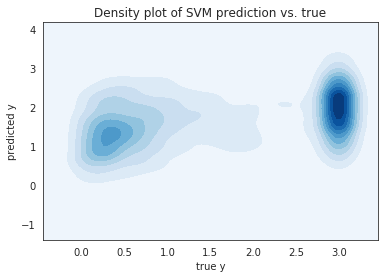

In [24]:
# plot performance
sns.set_style("white")
sns.kdeplot(bm_test_y, svm_pred_y, cmap="Blues", shade=True, shade_lowest=True, )
plt.title("Density plot of SVM prediction vs. true")
plt.xlabel("true y")
plt.ylabel("predicted y")
plt.show()


Text(0, 0.5, 'predicted y')

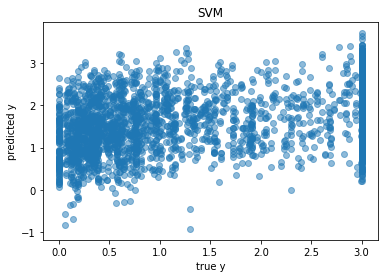

In [16]:
# plot pred vs. true
plt.figure()
plt.scatter(bm_test_y, svm_pred_y, alpha=0.5)
plt.title("SVM")
plt.xlabel("true y")
plt.ylabel("predicted y")

In [56]:
from scipy import stats

svm_prn = stats.pearsonr(bm_test_y, svm_pred_y)
svm_sprm = stats.spearmanr(bm_test_y, svm_pred_y)

print("Pearson R:",svm_prn[0])
print("Spearsman R:",svm_sprm[0])

Pearson R: 0.349831172078187
Spearsman R: 0.35662567444451704


In [ ]:
from sklearn.externals import joblib

# save model
filename = 'finalized_model.sav'
joblib.dump(svm_regr, filename)

In [70]:
# load model
loaded_model = joblib.load(filename)
loaded_pred = loaded_model.predict(s_bm_test_X)
print(metrics.mean_squared_error(bm_test_y,loaded_pred))

[1.61549907 1.65633505 2.05254305 ... 0.85928312 2.51726331 2.2144205 ]
